In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import pickle

## Load Dataset

In [2]:
X_train = pickle.load(open('../Data/train_enc.pkl', 'rb'))
X_test = pickle.load(open('../Data/test_enc.pkl', 'rb'))
y_train = pickle.load(open('../Data/y_train.pkl', 'rb'))
y_test = pickle.load(open('../Data/y_test.pkl', 'rb'))

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

torch.Size([329, 64])
torch.Size([83, 64])
(329,)
(83,)


## Perform exhaustive search for best parameters

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

gs = GridSearchCV(rf, param_grid, cv=3, n_jobs=-1, verbose=2)   # cv=3 means 3-fold cross validation
gs.fit(X_train, y_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 3, 5, 10],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200, 300]},
             verbose=2)

In [4]:
best_params = gs.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}


In [5]:
best_model = gs.best_estimator_
best_model

RandomForestClassifier(min_samples_leaf=2, n_estimators=50, random_state=42)

In [6]:
gs.cv_results_

{'mean_fit_time': array([0.2401286 , 0.45822024, 0.84522621, 1.29954743, 0.20264983,
        0.39803815, 0.87023616, 1.22120325, 0.22300617, 0.43135548,
        0.96020802, 1.61622469, 0.27927915, 0.42847387, 0.87027605,
        1.29698261, 0.20989227, 0.43945543, 0.86974414, 1.27873921,
        0.21184866, 0.41026727, 0.9164718 , 1.40556924, 0.19451578,
        0.56633671, 1.01735361, 1.60589004, 0.19849133, 0.78544958,
        1.02185059, 1.5050389 , 0.28579919, 0.43443775, 0.79728405,
        1.17078789, 0.19701926, 0.37036578, 0.83587933, 1.15706301,
        0.23437238, 0.39103389, 1.0632844 , 1.19842855, 0.2547996 ,
        0.4726905 , 0.82918978, 1.30284635, 0.22337794, 0.60357865,
        1.01960905, 1.36272422, 0.20434864, 0.40134271, 0.98848597,
        1.59244672, 0.27995976, 0.51453455, 0.93082833, 1.32539868,
        0.24270511, 0.43379394, 0.7879076 , 1.77609611, 0.20735097,
        0.65091419, 1.67392588, 1.88169138, 0.37026985, 0.71378096,
        1.44102017, 1.72527575,

## Evaluate model 

In [7]:
train_acc = gs.best_score_     # this is train accuracy
print("Train Accuracy:", train_acc)    

Train Accuracy: 0.9332221295524047


In [8]:
from sklearn.metrics import accuracy_score

y_pred_test = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.9156626506024096


In [9]:
from sklearn.metrics import roc_auc_score

auc_score = roc_auc_score(y_test, y_pred_test)
print("AUC Score:", auc_score)

AUC Score: 0.8288246268656716


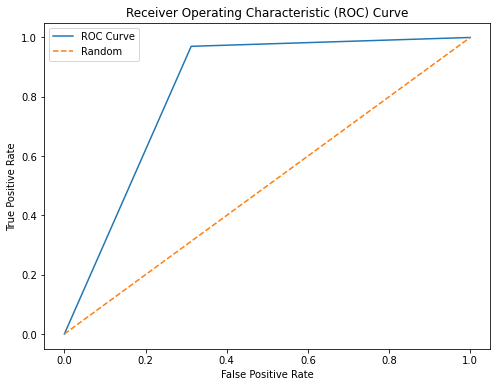

In [10]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

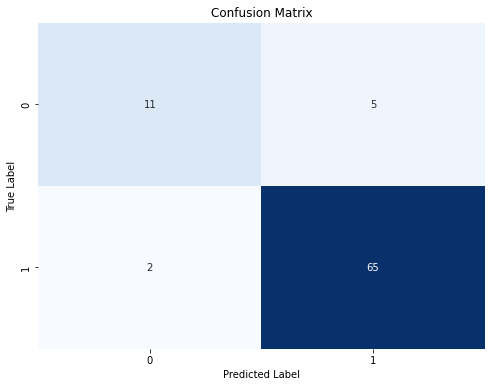

,precision,recall,f1-score,support
0,0.846154,0.687500,0.758621,16.000000
1,0.928571,0.970149,0.948905,67.000000
accuracy,0.915663,0.915663,0.915663,0.915663
macro avg,0.887363,0.828825,0.853763,83.000000
weighted avg,0.912684,0.915663,0.912224,83.000000


In [11]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# plot confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8, 6))
plt.title("Confusion Matrix")
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# print classification report as a df
cr = classification_report(y_test, y_pred_test, output_dict=True)
cr_df = pd.DataFrame(cr).transpose()
cr_df

In [12]:
rf_ae_dict = {
    'model': best_model,
    'train_acc': train_acc,
    'test_acc': test_accuracy,
    'auc_score': auc_score,
    'confusion_matrix': cm,
    'classification_report': cr_df
}

pickle.dump(rf_ae_dict, open('RF_AE.pkl', 'wb'))